---
# [pRFmodelFitter](https://linescanning.readthedocs.io/en/latest/classes/prf.html#linescanning.prf.pRFmodelFitting)

This page shows how I implement `pRF`-fitting routines on the back of [prfpy](https://github.com/VU-Cog-Sci/prfpy). You can quite easily fit data, save data, and load data back in. It also has quick visualizations to check certain characteristics of your pRF (e.g., location in visual space, it's raw timecourse, and the prediction given a model)

In [4]:
%matplotlib inline
from linescanning import prf, plotting, fitting
import numpy as np
import os
from scipy import io
import seaborn as sns
import matplotlib.pyplot as plt
opd = os.path.dirname
opj = os.path.join

In [5]:
# first we'll load some data (I provided a npy-file in the linescanning repo)
data = np.load(opj(opd(opd(prf.__file__)), 'examples', 'prf.npy'))
data.shape 

(225, 1)

The timecourse has 225 timepoints (standard for our pRF-acquisitions) and concerns 1 voxel. We can easily plot this timecourse with [LazyPlot](https://linescanning.readthedocs.io/en/latest/classes/plotting.html#linescanning.plotting.LazyPlot). We can also add some customization to make the timecourse look prettier

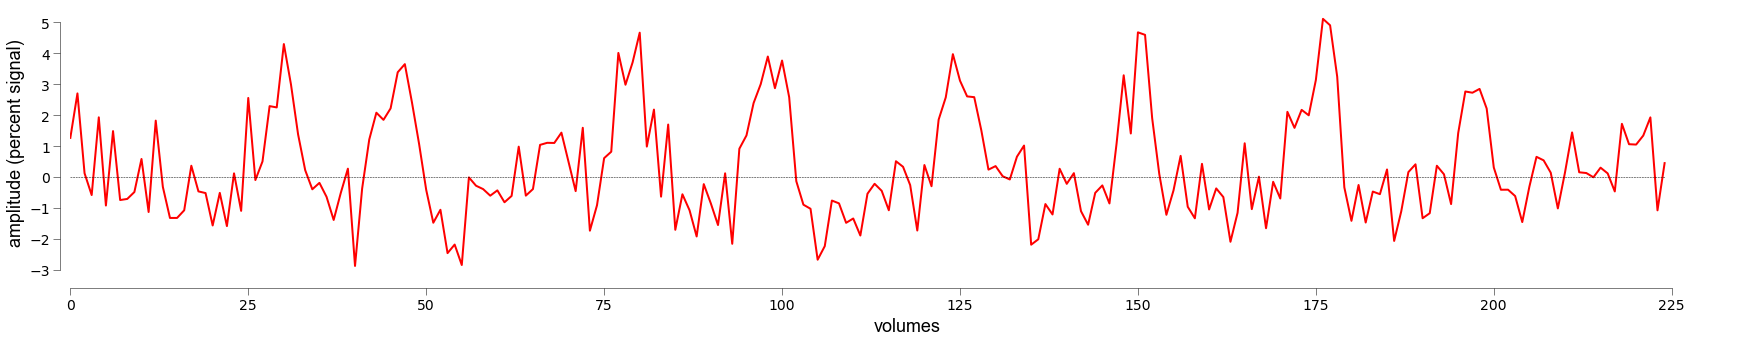

In [6]:
plotting.LazyPlot(data,
                  add_hline="default",                      # adds horizontal line at y=0
                  color='r',                                # sets color of plot
                  line_width=2,                             # line thickness
                  x_label="volumes",                        # x label
                  y_label="amplitude (percent signal)",     # y label
                  label_size=14,                            # font size of x/y ticks
                  font_size=18)                             # font size of labels

To know when the stimulus was at a given time point, we need the design matrix: a binarized representation of what happened on the screen. If you have a regular acquisition, you can use [get_prfdesign](https://linescanning.readthedocs.io/en/latest/classes/prf.html#linescanning.prf.get_prfdesign) to create your design matrix. For now, let's load in the matrix we have in the repository

In [7]:
# we have a .mat file, which we can load in with scipy.io.loadmat
design = io.loadmat(opj(opd(opd(prf.__file__)), 'examples', 'design_task-2R.mat'))
design

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Jul 27 12:05:39 2022',
 '__version__': '1.0',
 '__globals__': [],
 'stim': array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0.,

In [8]:
# As you can see, this is a dictionary. Not a numpy array. We can get the numpy array by selecting the `stim` attribute
design = design['stim']
print(design.shape)

# if you're not sure what the key is to find the design matrix, you can parse all the keys in the dictionary and select the last one
design = io.loadmat(opj(opd(opd(prf.__file__)), 'examples', 'design_task-2R.mat'))
key_list = list(design.keys())
print(key_list)

(100, 100, 225)
['__header__', '__version__', '__globals__', 'stim']


In [9]:
# now select the last item with -1
design = design[key_list[-1]]
design.shape

(100, 100, 225)

To make life easier, there's a function [read_par_file](https://linescanning.readthedocs.io/en/latest/classes/prf.html#linescanning.prf.read_par_file) than can do this for you

In [11]:
design = prf.read_par_file(opj(opd(opd(prf.__file__)), 'examples', 'design_task-2R.mat'))
design.shape

(100, 100, 225)

This particular design is now a representation of the screen, but downsampled to 100x100 pixels (rather than 1920x1080) to reduce processing time. A pRF-fit generally consists of two stages: a fast search (`grid`-fit) in which initial parameters for the model are found and a second, slower (`iterative`-fit), in which we iterate over the parameters to find the optimal set. Let's fit a simple `Gaussian` model.

In [16]:
# the data must be <voxels,time>, but above we have <time,voxels>. We therefore need to transpose our array
gauss = prf.pRFmodelFitting(
    data.T,
    design_matrix=design,
    TR=1.5,                     # default
    model='gauss',              # default, can be 'gauss', 'css', 'dog', 'norm'
    stage="grid+iter",          # default
    verbose=True,               # keep track of what we're doing,
    fix_bold_baseline=True      # fix the BOLD baseline at 0
    )

Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0]
HRF: <prfpy.model.HRF object at 0x7f36daa04610>


The stuff above just initializes everything, rather than actually fitting it. This is so we can also load existing parameters without fitting. But, for now, let's fit. We'll get back to the loading later. The settings used for the grids and stuff are specified in the default settings file: https://github.com/gjheij/linescanning/blob/main/misc/prf_analysis.yml. Change this to your liking, but generally the defaults are fine and in compliance with Marco Aqil's fitting procedures.


In [18]:
# fit
gauss.fit()

Starting gauss grid fit at 2022/08/12 12:17:04
Gaussian gridfit completed at 2022/08/12 12:17:21. voxels/vertices above 0.1: 1 out of 1
Gridfit took 0:00:16.303625
Mean rsq>0.1: 0.55
Starting gauss iterfit at 2022/08/12 12:17:21
Gaussian iterfit completed at 2022/08/12 12:17:30. Mean rsq>0.1: 0.53
Iterfit took 0:00:09.330091


With [plot_vox](https://linescanning.readthedocs.io/en/latest/classes/prf.html#linescanning.prf.pRFmodelFitting.plot_vox) (a function inside the `prf.pRFmodelFitting`-object; in this case `gauss`), we can quickly visualize the pRF-location, the timecourse, and the predicted timecourse for a given `vox_nr` (especially useful if you have 2D data). It will return a tuple containing the following: 

- The pRF estimates
- The pRF in visual field
- The actual BOLD timecourse
- The prediction

If you just want to see the timecourse and prf, use `_,_,_,_` to silence the output. The function relies on [LazyPlot](https://linescanning.readthedocs.io/en/latest/classes/plotting.html#linescanning.plotting.LazyPlot) and [LazyPRF](https://linescanning.readthedocs.io/en/latest/classes/plotting.html#linescanning.plotting.LazyPRF), so you can add the same level of customization as before, though `plot_vox` has some stuff set to default for you.

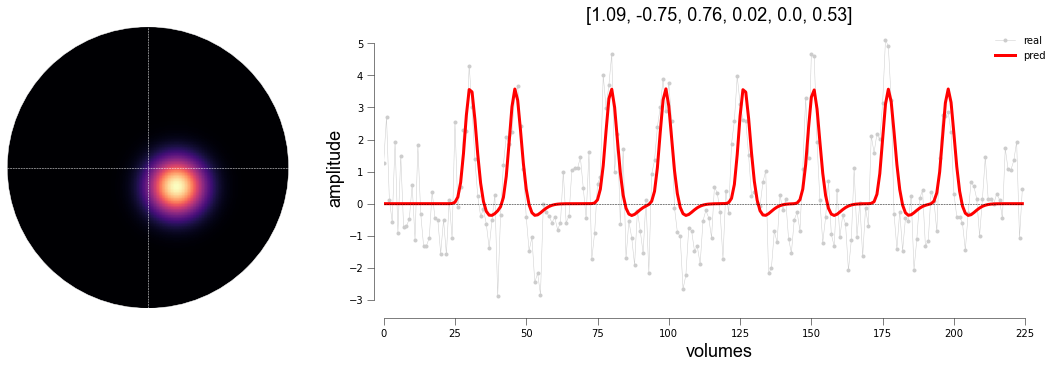

In [19]:
# plot the model fit
_,_,_,pred1 = gauss.plot_vox(vox_nr=0, title='pars')

With this model, we have a variance explained of `0.53` (or 53%) percent. We can see that the baseline is indeed fixed at 0, and that the peaks generally follow the stimulation period. We can improve this by using models that capture different kinds of characteristics, such as compression (`CSS`), surround suppression (`DoG`), or both (`Divisive Normalization` [DN])

In [20]:
# switching models is very easy. Every model that is NOT Gaussian will build on the Gaussian parameters. So, everytime your run such a model, it will re-fit the Gaussian parameters first. To avoid this, you can either specify the Gaussian fitter object (`gauss`) above as `previous_gaussian_fitter`-argument, or a numpy array as `old_params`-argument (which will create the `previous_gaussian_fitter` inside of the new object). Both options will make sure the Gaussian stage is skipped

# insert old parameters 
norm = prf.pRFmodelFitting(
    data.T,
    design_matrix=design,
    TR=1.5,
    model='norm',
    stage="grid+iter",
    verbose=True,
    fix_bold_baseline=True,
    old_params=gauss.gauss_iter, # less explicit
    )

norm = prf.pRFmodelFitting(
    data.T,
    design_matrix=design,
    TR=1.5,
    model='norm',
    stage="grid+iter",
    verbose=True,
    fix_bold_baseline=True,
    previous_gaussian_fitter=gauss.gaussian_fitter,  # very explicit
    )

# and fit
norm.fit()


Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0]
HRF: <prfpy.model.HRF object at 0x7f36daa14580>
Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0]
HRF: <prfpy.model.HRF object at 0x7f36daa14730>
Gaussian fitter: <prfpy.fit.Iso2DGaussianFitter object at 0x7f36dfb72ca0>
Starting norm grid fit at 2022/08/12 12:18:13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.7s finished


norm gridfit completed at 2022/08/12 12:18:14. Mean rsq>0.1: 0.55
Gridfit took 0:00:00.757664
Starting norm iterfit at 2022/08/12 12:18:14
norm iterfit completed at 2022/08/12 12:23:46. Mean rsq>0.1: 0.56
Iterfit took 0:05:32.453400


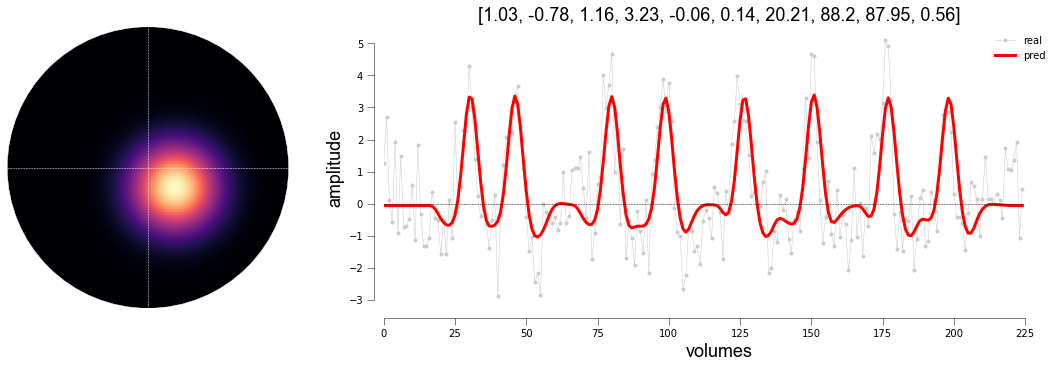

In [21]:
# plot the model fit
_,_,_,pred2 = norm.plot_vox(vox_nr=0, title='pars', model='norm')

This has improved the model fit marginally. We can plot the fits together as follows:

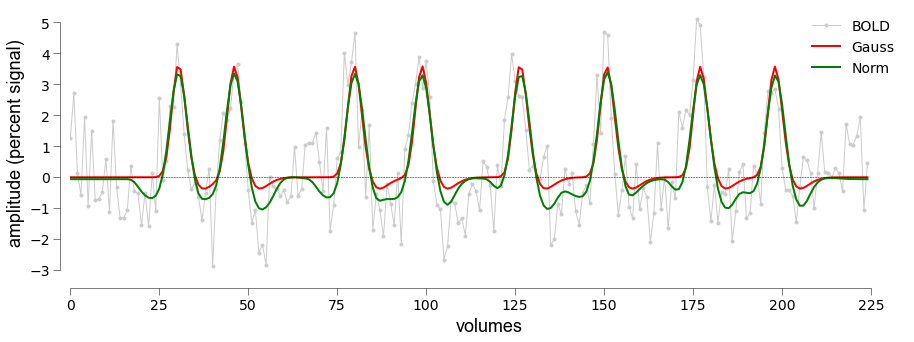

In [22]:
plotting.LazyPlot(
    [data,pred1,pred2],                       # list of multiple 1D-arrays
    add_hline="default",                      # adds horizontal line at y=0
    color=["#cccccc", 'r', "g"],              # list of same length as data (RGB/hex/strings)
    line_width=[1,2,2],                       # list of same length as data
    markers=['.',None,None],                  # plot BOLD as connected dots, predictions as solid lines
    x_label="volumes",                        # x label
    y_label="amplitude (percent signal)",     # y label
    label_size=14,                            # font size of x/y ticks
    figsize=(15,5),                           # set figure size
    labels=['BOLD','Gauss','Norm'],           # labels with the same length as data list
    font_size=18)                             # font size of labels


You can see that the normalization model is capturing different characteristics compared to the Gaussian model. Also note that the processing time was a lot longer compared to the Gaussian model. These are things to consider when selecting your model (for a few hundred voxels this is fine, but for >500000 it gets a bit complicated). You can speed this up by using `L-BGFS`-minimization over `trust-constr`-minimization. See doc of [pRFmodelFitting]()

Now let's look at saving and loading parameters. To save parameters, we need an output directory and the basename for the output. Some stuff will be appended depending on the stage, model, or whether the HRF was fitted as well.

In [49]:
# let's use the gaussian model because it's faster
gauss = prf.pRFmodelFitting(
    data.T,
    design_matrix=design,
    TR=1.5, 
    model='gauss',
    stage="grid+iter",
    verbose=True,
    fix_bold_baseline=True,
    write_files=True,                                   # set flag to write output
    output_dir=opj(opd(opd(prf.__file__)), 'examples'), # set custom output directory (defaults to current working directory)
    output_base="sub-01_ses-1"                          # set custom output basename; "_model-{model}_stage-{stage}_desc-prf_params.{pkl|npy}" is appended
    )

# fit
gauss.fit()


Instantiate HRF with: [1, 1, 0]
HRF: <prfpy.model.HRF object at 0x7f3fb907cc10>
Starting gauss grid fit at 2022/08/08 10:26:45
Gaussian gridfit completed at 2022/08/08 10:26:54. voxels/vertices above 0.1: 1 out of 1
Gridfit took 0:00:08.571527
Mean rsq>0.1: 0.55
Save grid-fit parameters in /mnt/d/FSL/shared/spinoza/programs/packages/linescanning/examples/sub-01_ses-1_model-gauss_stage-grid_desc-prf_params.npy
Starting gauss iterfit at 2022/08/08 10:26:54
Gaussian iterfit completed at 2022/08/08 10:26:54. Mean rsq>0.1: 0.55
Iterfit took 0:00:00.396051
Save iter-fit parameters in /mnt/d/FSL/shared/spinoza/programs/packages/linescanning/examples/sub-01_ses-1_model-gauss_stage-iter_desc-prf_params.npy
Save iter-fit predictions in /mnt/d/FSL/shared/spinoza/programs/packages/linescanning/examples/sub-01_ses-1_model-gauss_stage-iter_desc-predictions.npy


We see that stuff is save now in our specified directory with the basename of our choice. What `verbose` is not telling you is that we saved both a `npy`-file as well as a `pkl`-file  

In [50]:
os.listdir(opj(opd(opd(prf.__file__)), 'examples'))


['20220808_model-gauss_desc-settings.yml',
 'bold.mat',
 'design_task-2R.mat',
 'events.tsv',
 'figures',
 'prf.npy',
 'sub-01_ses-1_model-gauss_stage-grid_desc-prf_params.npy',
 'sub-01_ses-1_model-gauss_stage-grid_desc-prf_params.pkl',
 'sub-01_ses-1_model-gauss_stage-iter_desc-predictions.npy',
 'sub-01_ses-1_model-gauss_stage-iter_desc-prf_params.npy',
 'sub-01_ses-1_model-gauss_stage-iter_desc-prf_params.pkl']

This pickle file has more information in it compared to the numpy-file; for instance, it has the settings, predictions, and parameters embedded in it. We can use either file to load parameters in

In [51]:
# we initiate the model as per usual
gauss_load = prf.pRFmodelFitting(
    data.T,
    design_matrix=design,
    TR=1.5,
    verbose=True)

# decide which parameters you want to load. Here, let's load the parameters from the iterative Gaussian fit
load_pars = opj(opj(opd(opd(prf.__file__)), 'examples'), "sub-01_ses-1_model-gauss_stage-iter_desc-prf_params.pkl")

# We would then tell `gauss_load` to load this file in, and set the correct attributes internally. If there's no known settings, it will use the most recent settings file from the directory in which the to-be-loaded parameters live. If you specify a pickle file, these default settings will be overwritten by settings specified in the pickle-file
gauss_load.load_params(load_pars, model="gauss", stage="iter")

Instantiate HRF with: [1, 1, 0]
HRF: <prfpy.model.HRF object at 0x7f3fb900c670>
Reading settings from pickle-file (safest option; overwrites other settings)
Inserting parameters in 'gauss_iter' in <linescanning.prf.pRFmodelFitting object at 0x7f3fa83f0430>


We can now make the same plot again, but from an independent object (now `gauss_load`, rather than `gauss`)

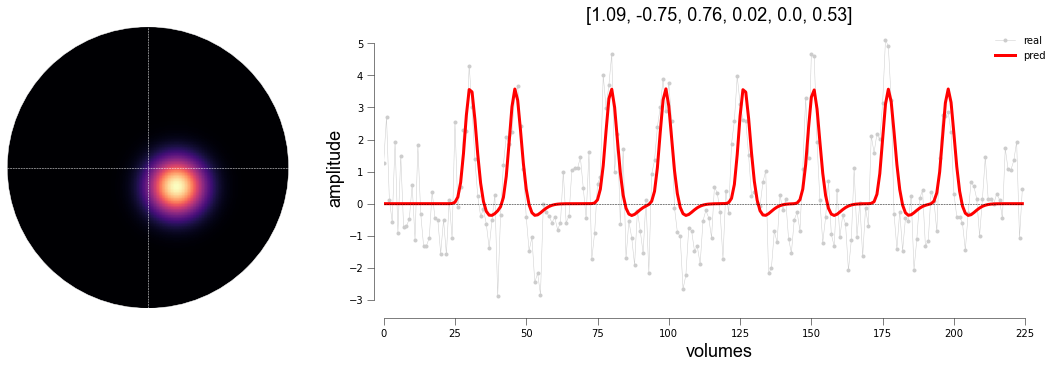

In [46]:
# plot the model fit
_, _, _, pred1 = gauss_load.plot_vox(vox_nr=0, title='pars')


If we try to plot the grid-parameters, that will fail. This is because `plot_vox` assumes you want the `iter`-parameters to be plotted, but we did not set that attribute inside `gauss_load`

In [53]:
_, _, _, _ = gauss_load.plot_vox(vox_nr=0, title='pars', stage="grid")


ValueError: Could not find grid parameters for gauss

It will also fail if we try to plot a model other than the one we specified (in our case, `gauss`), because we told the object to load in the parameters as `gauss`.

In [54]:
_, _, _, _ = gauss_load.plot_vox(vox_nr=0, title='pars', stage="iter", model="norm")


ValueError: Could not find iter parameters for norm

Finally, we can also fit the HRF-parameters during the pRF-modeling. This is handy if you expect differing HRFs across regions (or cortical depth). If you're doing this with models other than the Gaussian model, it's advised to do this in two stages: 

1) Fit your data without fitting the HRF
2) Then insert these parameters into a fit *with* HRF fitting

This is to avoid sending the fitter into the forest without a maps, as adding more parameters to a model increases model complexity. Given existing parameters to the fitter will tame the optimizer.

In [58]:
# stage 1: no HRF
stage1 = prf.pRFmodelFitting(
    data.T,
    design_matrix=design,
    TR=1.5, 
    model='norm',
    stage="grid+iter",
    verbose=True,
    fix_bold_baseline=True
    )

stage1.fit()

# stage 2: HRF with estimates from stage1
stage2 = prf.pRFmodelFitting(
    data.T,
    design_matrix=design,
    TR=1.5,
    model='norm',
    stage="grid+iter",
    verbose=True,
    fix_bold_baseline=True,
    fit_hrf=True,                                  # fit HRF,
    previous_gaussian_fitter=stage1.norm_fitter    # give existing parameters
    )

stage2.fit()


Instantiate HRF with: [1, 1, 0]
HRF: <prfpy.model.HRF object at 0x7f3fa8466040>
Starting gauss grid fit at 2022/08/08 10:45:15
Gaussian gridfit completed at 2022/08/08 10:45:23. voxels/vertices above 0.1: 1 out of 1
Gridfit took 0:00:07.929167
Mean rsq>0.1: 0.55
Starting gauss iterfit at 2022/08/08 10:45:23
Gaussian iterfit completed at 2022/08/08 10:45:23. Mean rsq>0.1: 0.55
Iterfit took 0:00:00.383555
Starting norm grid fit at 2022/08/08 10:45:23
Each batch contains approx. 1 voxels.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


norm gridfit completed at 2022/08/08 10:45:23. Mean rsq>0.1: 0.55
Gridfit took 0:00:00.354873
Starting norm iterfit at 2022/08/08 10:45:23
norm iterfit completed at 2022/08/08 10:50:30. Mean rsq>0.1: 0.56
Iterfit took 0:05:07.150723
Instantiate HRF with: [1, 1, 0]
HRF: <prfpy.model.HRF object at 0x7f3fb8d3e4f0>
Starting norm grid fit at 2022/08/08 10:50:31
Each batch contains approx. 1 voxels.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


norm gridfit completed at 2022/08/08 10:50:31. Mean rsq>0.1: 0.55
Gridfit took 0:00:00.352763
Starting norm iterfit at 2022/08/08 10:50:31
norm iterfit completed at 2022/08/08 10:57:23. Mean rsq>0.1: 0.63
Iterfit took 0:06:51.759228


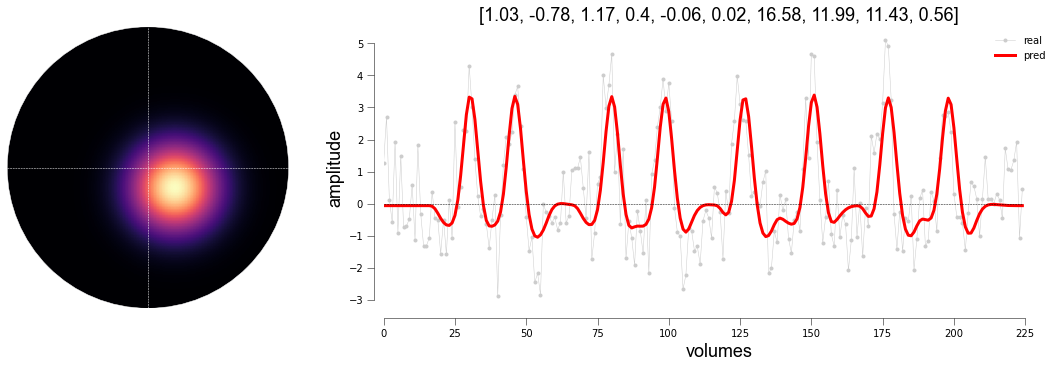

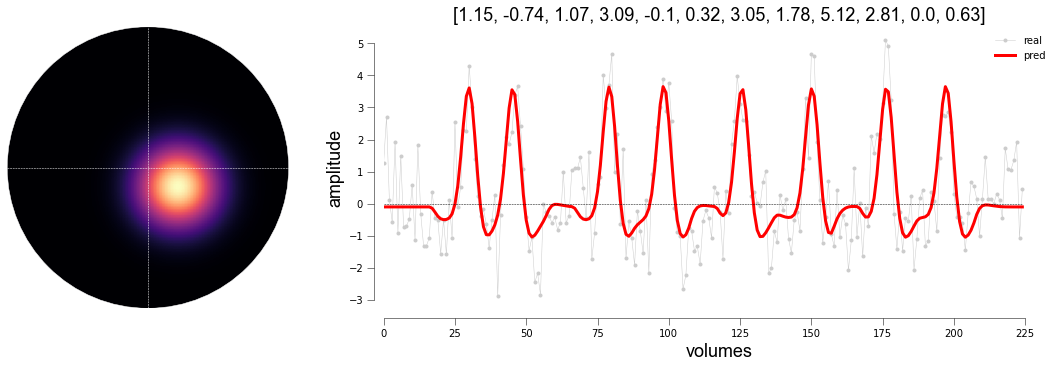

In [65]:
# plot the model fit
_, _, _, no_hrf = stage1.plot_vox(vox_nr=0, title='pars', model='norm')
_, _, _, with_hrf = stage2.plot_vox(vox_nr=0, title='pars', model='norm')

Again, you see that adding the HRF results in improved variance explained (`r2`): 0.56 vs 0.63. 

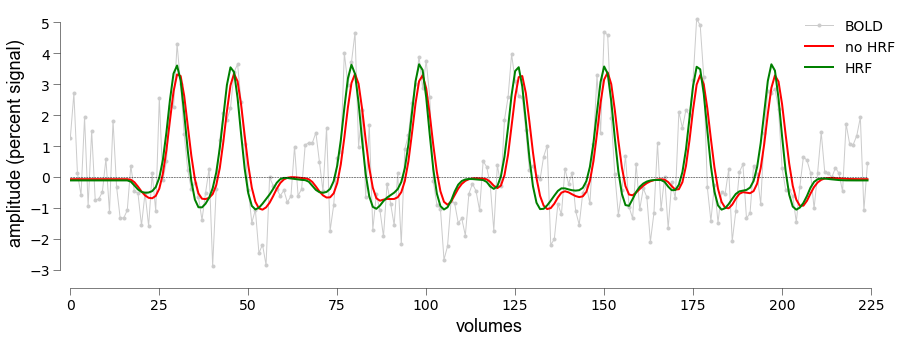

In [66]:
plotting.LazyPlot(
    [data,no_hrf,with_hrf],
    add_hline="default",
    color=["#cccccc", 'r', "g"],
    line_width=[1,2,2],
    markers=['.',None,None],
    x_label="volumes",
    y_label="amplitude (percent signal)",
    labels=['BOLD','no HRF','HRF'],
    label_size=14,
    figsize=(15,5),
    font_size=18) 

We can also plot the HRFs

In [79]:
hrf.create_spm_hrf(hrf_params=[1,1,0], TR=stage1.TR, force=True)
hrf.values

array([[ 0.00000000e+00,  1.37113043e-08,  9.40735935e-02,
         3.22602472e-01,  3.46819223e-01,  2.31413778e-01,
         1.15830107e-01,  4.11666735e-02, -6.04836035e-04,
        -2.19958748e-02, -3.02185028e-02, -2.97831734e-02,
        -2.45845234e-02, -1.78715593e-02, -1.17398067e-02,
        -7.08664845e-03, -3.97962789e-03, -2.09904918e-03,
        -1.04791606e-03, -4.98314196e-04, -2.26906278e-04,
        -9.93785163e-05, -4.20234727e-05, -1.72132945e-05,
        -6.84917100e-06, -2.65390853e-06, -1.00357143e-06]])

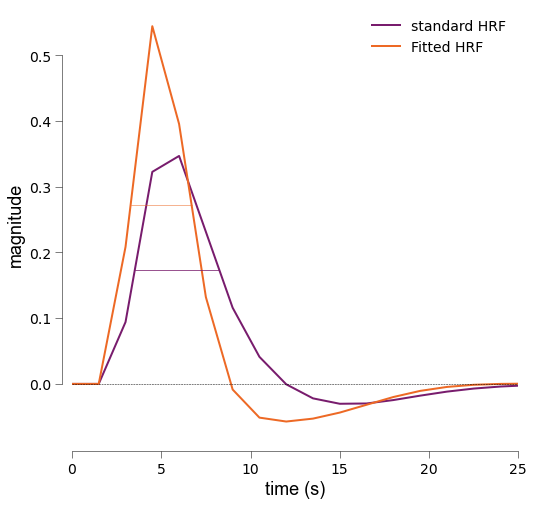

In [86]:
fig,axs = plt.subplots(figsize=(8,8))

# HRF is now created inside the object (a new feature of pRFpy)
stage1.hrf.create_spm_hrf(hrf_params=[1,1,0], TR=stage1.TR, force=True)
stage2.hrf.create_spm_hrf(hrf_params=[1, *stage2.norm_iter[0, -3:-1]], TR=stage1.TR, force=True)

hrfs = [stage1.hrf.values.T, stage2.hrf.values.T]
plotting.LazyPlot(
    hrfs, 
    labels=["standard HRF","Fitted HRF"], 
    xx=np.arange(0,40,stage2.TR),             # custom x-axis
    axs=axs,                                  # give existing axis to `LazyPlot` > allows you to put LazyPlot figures on different subplot axes
    label_size=14,
    font_size=18,
    line_width=2,
    x_lim=[0,25],
    add_hline='default',
    cmap='inferno',                           # custom color map
    x_label="time (s)",
    y_label="magnitude")

# get fwhm
colors = sns.color_palette('inferno', len(hrfs))
fwhm_objs = []
for hrf in hrfs:
    fwhm_objs.append(fitting.FWHM(np.arange(0,40,stage2.TR), hrf))

    # heights need to be adjusted for by axis length 
    xlim = axs.get_xlim()
    tot = sum(list(np.abs(xlim)))
    for ix, ii in enumerate(fwhm_objs):
        start = (ii.hmx[0]-xlim[0])/tot
        axs.axhline(ii.half_max, xmin=start, xmax=start+ii.fwhm/tot, color=colors[ix], linewidth=0.5)


We can see that the `Fitted HRF` is faster than the standard HRF; something would expect from 7T data